# Sentiment Classification with Keras


## Summary

The objective of the project is to build a neural network to predict the sentimient of a review. It is based on the Udacity project [Sentiment Classification](https://github.com/udacity/deep-learning/blob/master/sentiment-network/Sentiment_Classification_Solutions.ipynb) but some changes have been made. The main are:

- Keras library has been used to build the model and to see the learning progress.
- Cross validation has been used to evaluate the accuracy of the model. 



## Data loading and transforming

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


We load the data we are going to use to train the model. The reviews with their associated sentiment label:

In [2]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

In [3]:
from collections import Counter
import numpy as np

positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [4]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    if(labels[i] == 'POSITIVE'):
        for word in reviews[i].split(" "):
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in reviews[i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1

In [5]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [6]:
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    if(ratio > 1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1 / (ratio+0.01)))

To avoid noise we are going to incorporate in our vocabulary only the words which appears at least *min_count* times and we are enough sure they are not neutral words (absolute pos_neg_ratio bigger than polarity_cutoff = 0.5)

In [7]:
# populate review_vocab with all of the words in the given reviews

min_count = 20
polarity_cutoff = 0.5
review_vocab = set()
for review in reviews:
    for word in review.split(" "):
        if(total_counts[word] > min_count):
            if(word in pos_neg_ratios.keys()):
                if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                    review_vocab.add(word)
            else:
                review_vocab.add(word)

In [8]:
# Create a dictionary of words in the vocabulary mapped to index positions 
# (to be used in layer_0)

vocab = list(review_vocab)
vocab_len = len(vocab)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [9]:
def update_input_layer(review):
    """ Modify the global layer_0 to represent the vector form of review.
    The element at a given index of layer_0 should represent
    how many times the given word occurs in the review.
    Args:
        review(string) - the string of the review
    Returns:
        None
    """
    
    # clear out previous state, reset the layer to be all 0s
    layer_0 = np.zeros(vocab_len)
    
    # count how many times each word is used in the given review and store the results in layer_0 
    for word in review.split(" "):
        try:
            layer_0[word2index[word]] = 1
        except:
            continue
    return layer_0    

In [10]:
def get_target_for_label(label):
    """Convert a label to `0` or `1`.
    Args:
        label(string) - Either "POSITIVE" or "NEGATIVE".
    Returns:
        `0` or `1`.
    """
    if(label == 'POSITIVE'):
        return 1
    else:
        return 0

## Model building

In [11]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=len(vocab), kernel_initializer='uniform', activation='linear'))
model.add(Dense(1, activation='sigmoid'))

We set the initial learning_rate and set a decay_rate and a momentum to ensure a faster and accurate convergence of the training:

In [12]:
# Compile model
epochs = 150
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

## Model learning progress

In [13]:
X = np.array(list(map(update_input_layer, reviews)))
Y = np.array(list(map(get_target_for_label, labels)))

We are going to use the 33% of the data as validation data:

In [14]:
history = model.fit(X, Y, validation_split=0.33, epochs=epochs, batch_size=100, verbose=0)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


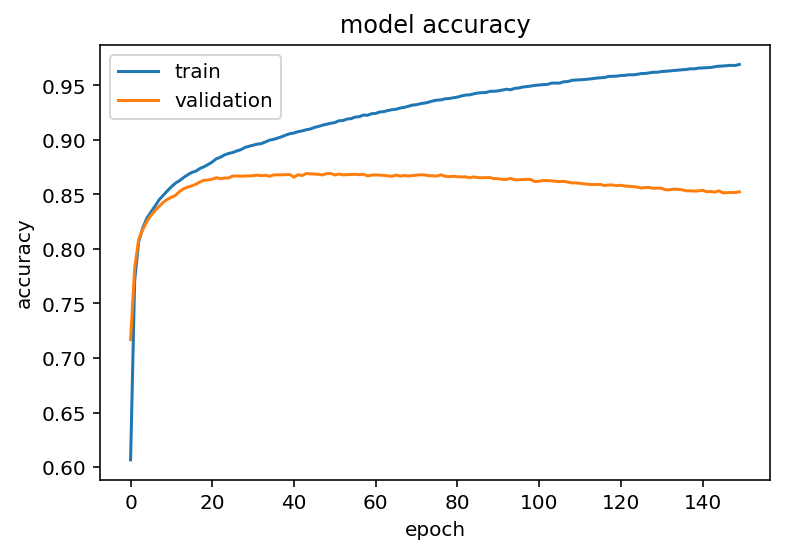

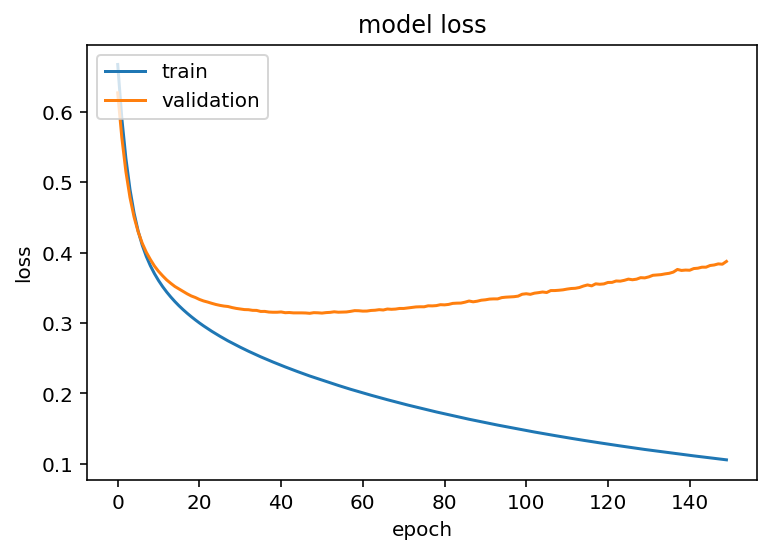

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training accuracy: 96.92% / Validation accuracy: 85.24%


It looks like there is some kind of overfitting: the accuracy goes up throughout epochs for training data and goes down for validation data.

## Model evaluation

The best way to evaluate the model is to use cross validation:

In [19]:
from sklearn.model_selection import StratifiedKFold

seed = 123
folds = 5
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
cvhistories = []
i = 0
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(10, input_dim=len(vocab), kernel_initializer='uniform', activation='linear'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    cvhistory = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), 
                          epochs=epochs, batch_size=100, verbose=0)
    print("Fold %d ==> Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
          (i, 100*cvhistory.history['acc'][-1], 100*cvhistory.history['val_acc'][-1]))    
    cvhistories.append(cvhistory)
    i+=1

Fold 0 ==> Training accuracy: 96.79% / Validation accuracy: 87.48%
Fold 1 ==> Training accuracy: 96.72% / Validation accuracy: 87.76%
Fold 2 ==> Training accuracy: 96.80% / Validation accuracy: 87.00%
Fold 3 ==> Training accuracy: 96.80% / Validation accuracy: 86.84%
Fold 4 ==> Training accuracy: 97.00% / Validation accuracy: 87.50%


In [20]:
training_mean_accuracy = np.zeros(150) 
validation_mean_accuracy = np.zeros(150) 
training_mean_loss = np.zeros(150) 
validation_mean_loss = np.zeros(150) 
for i in range(folds):
    training_mean_accuracy += np.array(cvhistories[i].history['acc'])
    validation_mean_accuracy += np.array(cvhistories[i].history['val_acc'])
    training_mean_loss += np.array(cvhistories[i].history['loss'])
    validation_mean_loss += np.array(cvhistories[i].history['val_loss'])    
training_mean_accuracy = training_mean_accuracy / folds    
validation_mean_accuracy = validation_mean_accuracy / folds
training_mean_loss = training_mean_loss / folds    
validation_mean_loss = validation_mean_loss / folds

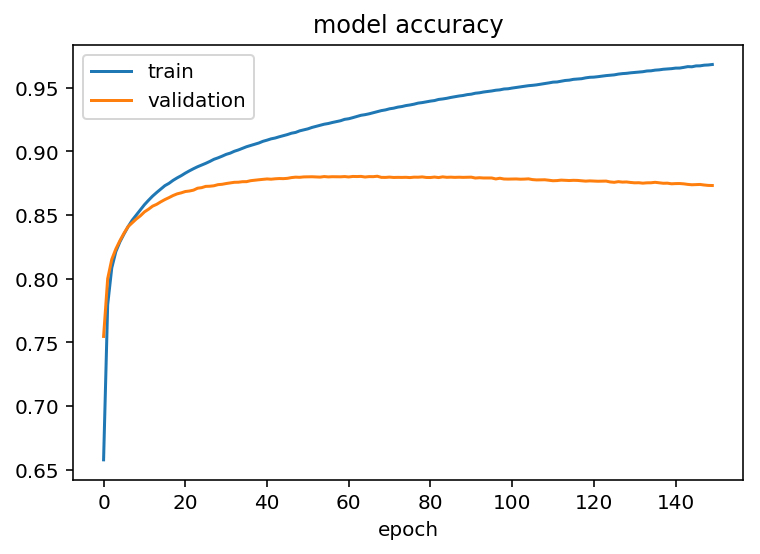

In [21]:
plt.plot(training_mean_accuracy)
plt.plot(validation_mean_accuracy)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

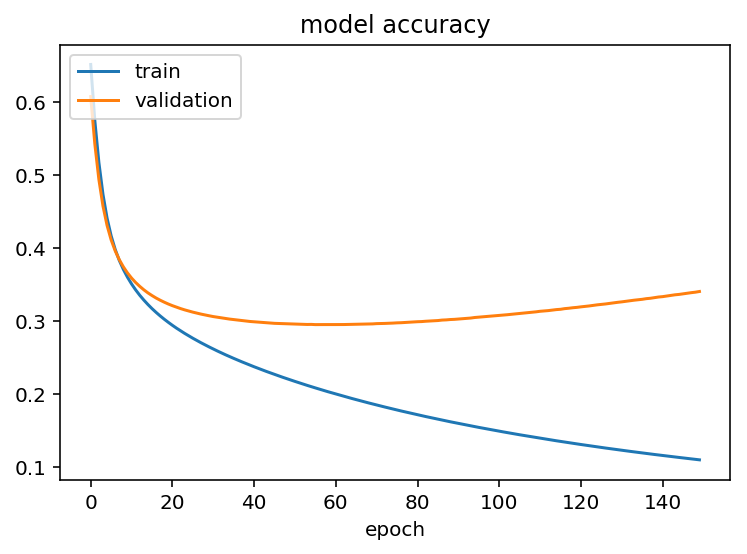

In [22]:
plt.plot(training_mean_loss)
plt.plot(validation_mean_loss)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

At the end of the training (max epoch) we calculate the accuracy as the mean of all folds:

In [52]:
print("Training mean accuracy: %.2f%% / Validation mean accuracy: %.2f%%" % 
          (100*training_mean_accuracy[-1], 100*validation_mean_accuracy[-1]))

Training mean accuracy: 96.82% / Validation mean accuracy: 87.32%


In [53]:
training_std_accuracy = np.std([cvhistories[i].history['acc'][-1] for i in range(folds)])
validation_std_accuracy = np.std([cvhistories[i].history['val_acc'][-1] for i in range(folds)])

print("Training accuracy: %.2f%% (+/- %.2f%%) \nValidation accuracy: %.2f%% (+/- %.2f%%)" % 
          (100*training_mean_accuracy[-1], training_std_accuracy*100,
          100*validation_mean_accuracy[-1], validation_std_accuracy*100))



Training accuracy: 96.82% (+/- 0.09%) 
Validation accuracy: 87.32% (+/- 0.34%)


It looks like we have the best validation accuracy for epoch 67:

In [54]:
best_epoch = validation_mean_accuracy.argmax(axis=0)
best_epoch

67

In [55]:
best_validation_accuracy = validation_mean_accuracy[best_epoch]
best_validation_accuracy

0.88043999934196471

In [56]:
best_std_accuracy = np.std([cvhistories[i].history['val_acc'][best_epoch] for i in range(folds)])

In [57]:
print("Best Validation accuracy: %.2f%% (+/- %.2f%%)" % 
          (100*best_validation_accuracy, best_std_accuracy*100))



Best Validation accuracy: 88.04% (+/- 0.37%)


## Predictions

Let's try the model to predict some reviews:

In [58]:
def get_sentiment(review):
    vectorized_review = update_input_layer(review).reshape(1,-1)
    res = model.predict(vectorized_review)
    if(res >= 0.5):
        return "POSITIVE"
    else:
        return "NEGATIVE"

In [59]:
reviews[5]

'this film lacked something i couldn  t put my finger on at first charisma on the part of the leading actress . this inevitably translated to lack of chemistry when she shared the screen with her leading man . even the romantic scenes came across as being merely the actors at play . it could very well have been the director who miscalculated what he needed from the actors . i just don  t know .  br    br   but could it have been the screenplay  just exactly who was the chef in love with  he seemed more enamored of his culinary skills and restaurant  and ultimately of himself and his youthful exploits  than of anybody or anything else . he never convinced me he was in love with the princess .  br    br   i was disappointed in this movie . but  don  t forget it was nominated for an oscar  so judge for yourself .  '

In [60]:
get_sentiment(reviews[5])

'NEGATIVE'

In [61]:
reviews[9130]


'i would just like to say  that no matter how low budget the film is  it needs to be shown throughout this world the point to these movies . we don  t read that much anymore  instead people want to see movies . having this series out on dvd  has made me want to read the whole series  and want more . please make all  movies . please don  t change any of the characters either  it ruins the effect . because i have grown to love the actors who have played the characters . please make all  movies . i want to see the message  and watch the message that these books and now movies are here to portray . we don  t get that enough anymore . awesome job     '

In [62]:
get_sentiment(reviews[9130])

'POSITIVE'

## References

- [Sentiment Classification](https://github.com/udacity/deep-learning/blob/master/sentiment-network/Sentiment_Classification_Solutions.ipynb) 
- [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/index.html)
- [Develop Your First Neural Network in Python With Keras Step-By-Step](http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](http://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
